# A second epidemiological modelling approach (SEIR) to understand ICU usage during COVID pandemic

**By**: Kaike Wesley Reis

**Contact**: kaikewesley@hotmail.com

![corona illustration](https://user-images.githubusercontent.com/32513366/79788955-d3459900-831f-11ea-883c-2eba6c4dadfa.gif)

## Task - Which populations have contracted COVID-19 who require the ICU? And when does this occur in their disease course?

ICU is really important? Technically, Yes. They are really important, because the person that needs ICU and doesn't get will probably **die**.

## Proposed approach
**Abstract**: The main goal here is to understand how ICU usage will grows during COVID pandemic to answer the task here. To realize this I presented for each case study an exploratory data analysis (EDA) to comprehend my dataset and a comportmental model analysis to predict different scenarios for ICU usage (if possible). 

At my first submission I used an epidemiological model called [**SIR Model**](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model), but given my studies in COVID-19 and epidemiological models I realize that [**SEIR Model**](http://www.public.asu.edu/~hnesse/classes/seir.html) is more suitable for this analysis (this trade have your explanation in **SEIR Model Analysis** topic). SEIR Model will be used to understand how the number of infected will grow over time and consequently the amount of ICU that will be needed. To further explanation, please go to section **SEIR Model Analysis**.

## Summary
- **Data pre-processing**
- **SEIR Model Analysis**
- **Case study I: Italy**
    - Exploratory Data Analysis
    - SEIR Model Solution
    - SEIR predictions until July
    - ICU usage analysis with different scenarios
- **Case study II: Spain**
    - Exploratory Data Analysis
    - SEIR Model Solution
    - SEIR predictions until July
    - ICU usage analysis with different scenarios
- **Case study III: Brazil**
    - Missing Analysis
    - Exploratory Data Analysis
- **Overall conclusions**

**PS**: Use Kaggle native summary to navigate through those topics.

## Submissions Historic
### Deadline 1/3
- Application of SIR compartmental model
- Case study for Italy using SIR and Exploratory Data Analysis (EDA)
- Predictions for ICU usage until July/2020

### Deadline 2/3
- Change modelling approach from SIR to SEIR
- Update **Italy** case study from SIR to SEIR
- New case study: **Spain** with SEIR and EDA
- New case study: **Brazil** with Missing Analysis and EDA
- ICU usage analysis with different scenarios

## Modules

In [1]:
# Standard modules
import numpy as np

# Data modules
import pandas as pd

# Missing Analysis modules
import missingno as msno

# Modelling modules
from scipy import integrate
from scipy import optimize

# Plot modules
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Pre-processing data
Step to import, clean and process the data.

## Importing datasets

In [2]:
# Italy
df_ita_status = pd.read_csv('/kaggle/input/uncover/UNCOVER/github/covid-19-italy-situation-monitoring-by-region.csv')

In [3]:
# Spain
df_spn_status = pd.read_csv('/kaggle/input/uncover/UNCOVER/github/covid19-spain-cases.csv')

In [4]:
# Brazil
df_bra_status = pd.read_csv('/kaggle/input/uncover/UNCOVER/einstein/diagnosis-of-covid-19-and-its-clinical-spectrum.csv')

## Removing unused columns
Given the work with SEIR model, I will keep only the columns related to my study.

In [5]:
# Italy
df_ita_status.drop(axis=1, inplace=True, columns=['stato', 'lat', 'long', 'note_it', 'note_en', 'codice_regione', 'denominazione_regione'])

In [6]:
# Spain
df_spn_status.drop(axis=1, inplace=True, columns=['ccaa','ia', 'muertes', 'hospitalizados', 'nuevos'])

In [7]:
# Brazil
## Get only COVID-19 positive cases
df_bra_status = df_bra_status[df_bra_status['sars_cov_2_exam_result'] == 'positive']
## Remove unused columns
df_bra_status.drop(axis=1, inplace=True, columns=['patient_id', 'sars_cov_2_exam_result'])
## Change index
df_bra_status.index = range(0, len(df_bra_status))

## Create work dataframes
Basically, in this section I will:
- **Italy** and **Spain**
    - Group all the columns: *cases*, *infected* and *recovered*  based in *date* variable, which means a ```df``` with reports for that country in this specific day
    - Change columns names to have a specific pattern (turn my life easier) for Italy and Spain
- **Brazil**
    - Create a categorical column related to patient destination: ```no hospitalization```, ```regular ward```, ```semi intensive unit``` and ```intensive care unit```
    - Drop unused columns

In [8]:
# ITALY
## Group by date
ita_status = df_ita_status[['data', 'totale_casi', 'terapia_intensiva','dimessi_guariti']].groupby('data').sum().reset_index()
## Change columns to a specific pattern
ita_status.columns = ['date','infected','icu','recovered']

In [9]:
# SPAIN
## Group by date
spn_status = df_spn_status[['fecha', 'casos', 'uci', 'curados']].groupby('fecha').sum().reset_index()
## Change columns to a specific pattern
spn_status.columns = ['date','infected','icu','recovered']

In [10]:
# BRAZIL
## Create categorical column for patient destination
df_bra_status['patient_destination'] = np.nan
## Loop to insert values
for i in range(0, len(df_bra_status)):
    # Var that holds patient destination
    patient_state = (df_bra_status.loc[i,'patient_addmited_to_regular_ward_1_yes_0_no'], df_bra_status.loc[i, 'patient_addmited_to_semi_intensive_unit_1_yes_0_no'], df_bra_status.loc[i, 'patient_addmited_to_intensive_care_unit_1_yes_0_no'])
    # Define value
    if patient_state == ('f', 'f', 'f'): 
        df_bra_status.loc[i, 'patient_destination'] = 'no_hospitalization'
    elif patient_state == ('t', 'f', 'f'):
        df_bra_status.loc[i, 'patient_destination'] = 'regular_ward'
    elif patient_state == ('f', 't', 'f'):
        df_bra_status.loc[i, 'patient_destination'] = 'semi_intensive_unit'
    elif patient_state == ('f', 'f', 't'):
        df_bra_status.loc[i, 'patient_destination'] = 'intensive_care_unit'
## Drop again unused columns
df_bra_status.drop(axis=1, inplace=True, columns=['patient_addmited_to_regular_ward_1_yes_0_no', 'patient_addmited_to_semi_intensive_unit_1_yes_0_no', 'patient_addmited_to_intensive_care_unit_1_yes_0_no'])

## Important Assumption
Given this groupby in Italy and Spain, you can see that I'm looking to the country as one piece. My analysis is not looking to any specific country region specifically, **but** the same procedure can be applied for a region if you wanted. As a prove you can see my notebook related to [ventilators task](https://www.kaggle.com/kaikewreis/a-case-study-analysis-ventilators-distributions?scriptVersionId=32792458) in this same challenge, where I look for specific regions in Italy.

Anyway, my goal here is to present an overview about how you can understand the pandemic situation through an epidemiological model and visualize ICU necessity.

# SEIR Model Analysis

## Why I moved from SIR to SEIR model?

SEIR approach present a new variable: Exposed (E). That variable is related to the population fraction that get the virus, but didn't present the symptoms yet. This situation is important in pandemics that have an incubation phase, something well known with regard to COVID-19 that presents this phase. Given the fact that SEIR can improve my pandemic dynamic studies I moved on with SEIR.

## Model background

SEIR is a set (system) of ODE (Ordinary Differencial Equations) which models the dynamics of four main dependent variables over time during a pandemic:
- **S(t)**: Suscetible cases
- **E(t)**: Exposed cases
- **I(t)**: Infected cases
- **R(t)**: Recovered cases

The mathematical equation is presented bellow:
![seir](https://user-images.githubusercontent.com/32513366/80239696-101ed200-8637-11ea-8ace-918fb5d98076.PNG)

The dynamics between then are correlated and reminds SIR system (if you saw my first submission). For more modelling information I strongly recommend the [MAA SIR reading](https://www.maa.org/press/periodicals/loci/joma/the-sir-model-for-spread-of-disease-the-differential-equation-model) and [Numberphile - The corona curve](https://www.youtube.com/watch?v=k6nLfCbAzgo) to understand SIR model (it helps to understand this model too) and a [SEIR Model doc](http://www.public.asu.edu/~hnesse/classes/seir.html).

In red, I specify the parameters that control SEIR curves:
- **er**: exposed rate
- **ir**: infection rate
- **rr**: recovery rate

So when you hear:

### "Flatten the Corona curve" 

The objective is to decrease infection rate as well to flatten the Infection curve. This is achieve by lockdown/isolation techniques.

A higher recovery rate is desired too, because the number of people in hospitals tends to decrease.


This ODE system present your dependent variables (s, i, e and r) in lowercase. This statement is important because for my solution I will evaluate fraction values related to population size (N):
![SEIR_CR](https://user-images.githubusercontent.com/32513366/80240551-65a7ae80-8638-11ea-8784-6edad80e0ba2.PNG)

## But how I will develop this model?
Given the fact that I have:
- A model approach: SEIR
- Initial curves for Infected and Recovered cases

I will implement an **optimization technique** to find the actual parameters that minimize my error for both initial curves: i(t) and r(t).

In [11]:
# FUNCTION - Define SEIR Model ODE System
def seir_model_ode(y, t, params): 
    '''
    Arguments:
    - y: dependent variables
    - t: independent variable (time)
    - params: Model params
    '''
    # Parameters to find
    infection_rate = params[0]
    recovery_rate = params[1]
    exposed_rate = params[2]
    
    # Y variables
    s = y[0]
    e = y[1]
    i = y[2]
    r = y[3]
    
    # SIR EDO System 
    dsdt = -exposed_rate*s*i
    dedt = (exposed_rate*s*i) - (infection_rate*e)
    didt = (infection_rate*e) - (recovery_rate*i)
    drdt = recovery_rate*i
    
    # Return our system
    return (dsdt, dedt, didt, drdt)

In [12]:
# FUNCTION - Calculate SEIR Model in t (time as days) based on given parameters
def calculate_seir_model(params, t, initial_condition):
    # Create an alias to our seir ode model to pass params to try
    seir_ode = lambda y,t:seir_model_ode(y, t, params)
    
    # Calculate ode solution, return values to each
    ode_result = integrate.odeint(func=seir_ode, y0=initial_condition, t=t)
    
    # Return results
    return ode_result

In [13]:
# FUNCTION - Auxiliar function to find the best parameters
def fit_seir_model(params_to_fit, t, initial_condition, i_r_true):
    # Calculate ODE solution for possible parameter, return values to each dependent variable:
    # (s, e, i and r)
    fit_result = calculate_seir_model(params_to_fit, t, initial_condition)
    
    # Calculate residual value between predicted VS true
    ## Note: ode_result[0] is S result
    residual_i = i_r_true[0] - fit_result[:,2]
    residual_r = i_r_true[1] - fit_result[:,3]

    # Create a np.array of all residual values for both (i) and (r)
    residual = np.concatenate((residual_i, residual_r))
    
    # Return results
    return residual

The optimization solution was based in this [stackoverflow answer](https://stackoverflow.com/questions/11278836/fitting-data-to-system-of-odes-using-python-via-scipy-numpy).

# Case Study I: ITALY
![image](https://user-images.githubusercontent.com/32513366/79917951-e6309a00-8401-11ea-8d7e-4e4afbac712b.png)

**But, why Italy?** Italy was the country that showed the worst situation in europe when was afflicted by Corona virus, which alert all countries around the globe. The most symbolic and sad situation was the scene of [army trucks carrying bodies to be cremated](https://metro.co.uk/2020/03/19/army-trucks-filled-bodies-overflowing-morgues-drive-streets-italy-12423685/).

An Italy analysis for the proposed task can give insights to other countries during this crysis.

## Exploratory Data Analysis


### COVID-19 Italy Development
Here I will visualize each curve for:
- Infected
- Recovered
- ICU

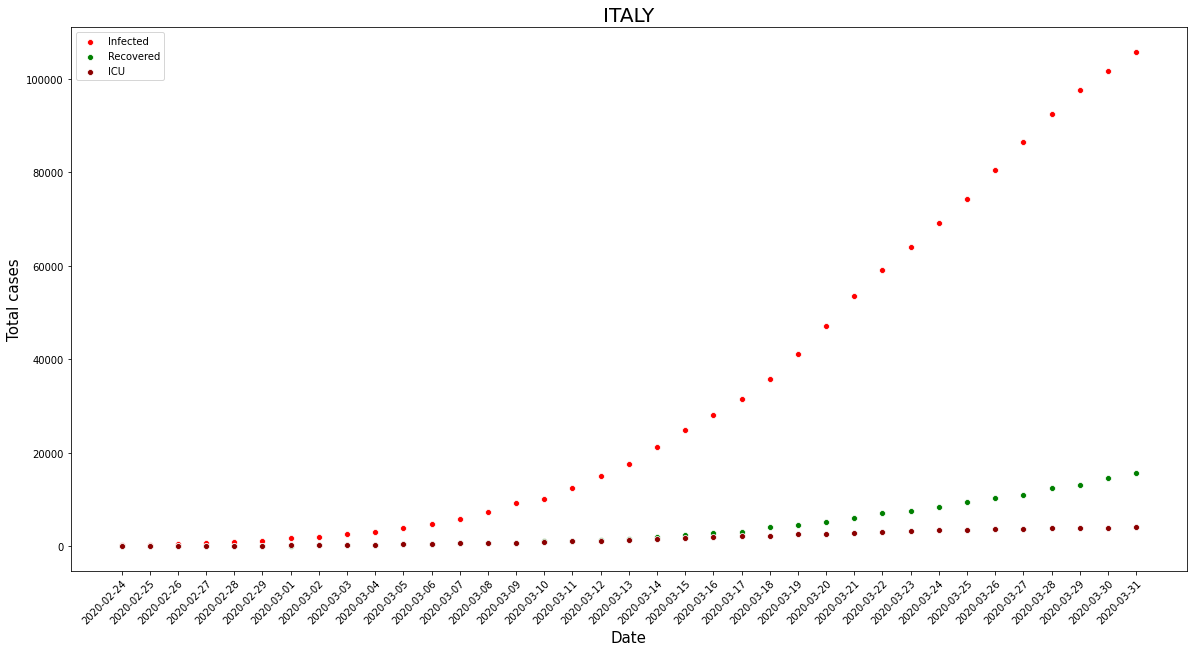

In [14]:
# Define plot object
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,10))

# Define df to plot here!
df = ita_status

# Plots - ITALY
sns.scatterplot(x='date', y='infected', data=df, ax=axes, color = 'red')
sns.scatterplot(x='date', y='recovered', data=df, ax=axes, color = 'green')
sns.scatterplot(x='date', y='icu', data=df, ax=axes, color = 'darkred')
plt.setp(axes.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
axes.legend(loc=2, labels=['Infected','Recovered','ICU'], fontsize=10)
axes.set_title('ITALY', fontsize=20)
axes.set_xlabel('Date', fontsize=15)
axes.set_ylabel('Total cases', fontsize=15);

### Commentary:
- Infected curve , in red, grows exponentially
- Recovered curve, in green, after some time grows with Infected curve
- ICU curve, in dark red, increase with a smaller percentage of Infected curve. 

The last topic reminds an OMS Statement: **5% of infected cases will require a ICU**. So it's known that ICU usage is higher correlated to Infected cases.

### ICU Ratio
Here I will eval through a plot the ICU ratio related to Infected cases.

In [15]:
# Create a icu_ratio in % for ITALY
for i in range(0, len(ita_status)):
    ita_status.loc[i, 'icu_ratio'] = round(100*(float(ita_status.loc[i, 'icu'])/float(ita_status.loc[i, 'infected'])), 2)

In [16]:
# Get some fast statistics: maximum, minimum and average ICU ratio - ITALY
print('### Italy')
print('Maximum ICU ratio: ', np.nanmax(ita_status['icu_ratio']))
print('Average ICU ratio: ', round(np.nanmean(ita_status['icu_ratio']),2))
print('Minimum ICU ratio: ', np.nanmin(ita_status['icu_ratio']))

### Italy
Maximum ICU ratio:  11.35
Average ICU ratio:  7.13
Minimum ICU ratio:  3.8


### Commentary:

- we can see that Italy presented a worst scenario compared to OMS statement (5% of infected will need ICU).

Let's see the ICU ratio through time:

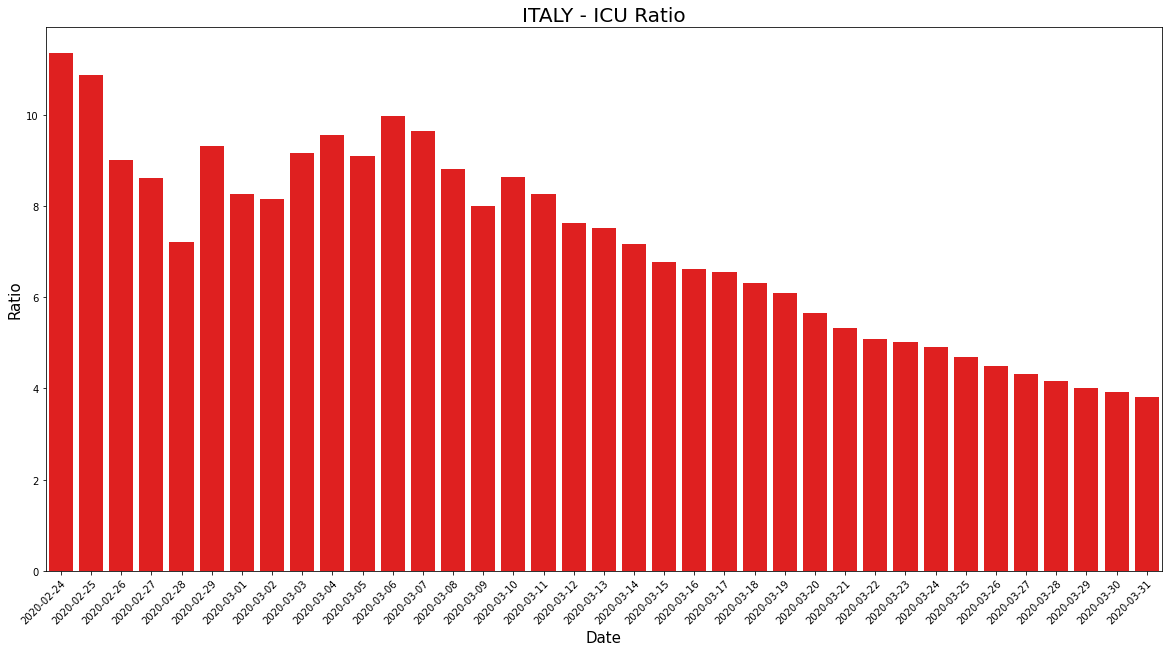

In [17]:
# Define plot object
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,10))

# Define df to plot here!
df = ita_status

# Plot - ITALY
sns.barplot(x='date', y='icu_ratio', data=df, ax=axes, color = 'red')
plt.setp(axes.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
axes.set_title('ITALY - ICU Ratio', fontsize=20)
axes.set_xlabel('Date', fontsize=15)
axes.set_ylabel('Ratio', fontsize=15);

### Commentary:
- Italy shows a decrease ICU usage (a good sign)

## SEIR Model Solution

### Define [country population (N) in Italy](https://simple.wikipedia.org/wiki/Italy)

In [18]:
# Country population (~)
N = 1000000*60.59

### Define start conditions
Acording to WHO (World Health Organization), the [average incubation period is **5 days**](https://www.who.int/news-room/q-a-detail/q-a-coronaviruses#:~:text=The%20%E2%80%9Cincubation%20period%E2%80%9D,more%20data%20become%20available.). I will use this info to set my initial condition for e(t) based in a assumption:

**e(0) = i(5) - i(4)**

i.e. I assume that my initial exposed value is equal all the new infected cases in day 5.

For **s(0)**, I assume:

**s(0) = 1 - e(0) - i(0)**

i.e. my initial suscetible value is equal 1 (Total population) minus exposed and infected portion.

In [19]:
# Define Initial Condition (necessary for ODE solve)
I_start = ita_status.loc[0, 'infected']/N
E_start = (ita_status.loc[4, 'infected'] - ita_status.loc[3, 'infected'])/N
S_start = 1 - E_start - I_start
R_start = ita_status.loc[0, 'recovered']/N
## Set this values as a tuple
ic = (S_start, E_start, I_start, R_start)

In [20]:
print('Start condition:')
print('s(0): ', ic[0])
print('e(0): ', ic[1])
print('i(0): ', ic[2])
print('r(0): ', ic[3])

Start condition:
s(0):  0.9999922924575012
e(0):  3.928040930846674e-06
i(0):  3.7795015679154976e-06
r(0):  1.650437365901964e-08


### Prepare data to optimization

In [21]:
# Define a time array measure in days
time_opt = range(0, len(ita_status))

# Create a tuple with the true values in fraction for Infected/Recovered cases (necessary for error measurement)
i_r_true = (list(ita_status['infected']/N), list(ita_status['recovered']/N))

# Define a start guess for our parameters [infection_rate, recovered rate]
params_start_guess = [0.01, 0.001, 0.01]

### Optimization process

In [22]:
optimal_params, sucess = optimize.leastsq(fit_seir_model,
                                          x0=params_start_guess,
                                          args=(time_opt, ic, i_r_true),
                                          ftol=1.49012e-15)

In [23]:
print('## Italy')
print('Optimize infection rate: ', optimal_params[0])
print('Optimize recovered rate: ', optimal_params[1])
print('Optimize exposed rate: ', optimal_params[2])

## Italy
Optimize infection rate:  3.113158886790798
Optimize recovered rate:  0.021945658088431495
Optimize exposed rate:  0.1921314823625073


### Compare the curves (true/pred)

In [24]:
# Get the optimal parameters
ir = optimal_params[0]
rr = optimal_params[1]
er = optimal_params[2]

In [25]:
# Calculate a curve based on those parameters
fit_result = calculate_seir_model((ir, rr, er), time_opt, ic)

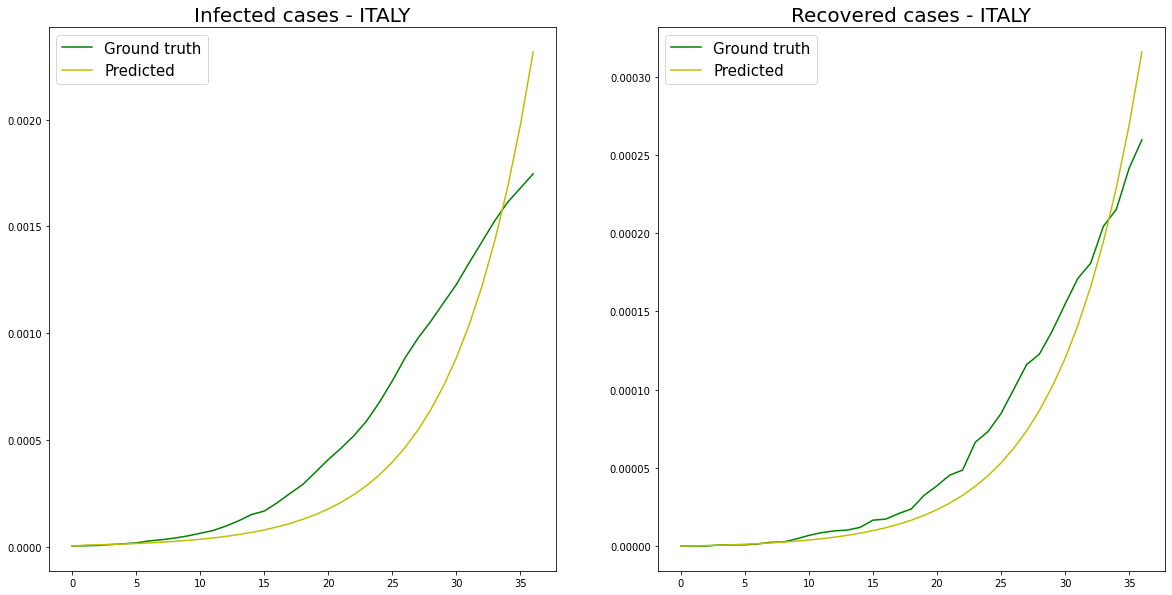

In [26]:
# Plot the results for Infected/Recovered
## Define plot object
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

## Plot process
axes[0].plot(time_opt, i_r_true[0], 'g')
axes[0].plot(time_opt, fit_result[:,2], 'y')
axes[0].legend(['Ground truth', 'Predicted'],loc=2, fontsize=15)
axes[0].set_title('Infected cases - ITALY',fontsize=20)
axes[1].plot(time_opt, i_r_true[1], 'g')
axes[1].plot(time_opt, fit_result[:,3], 'y')
axes[1].legend(['Ground truth', 'Predicted'],loc=2, fontsize=15)
axes[1].set_title('Recovered cases - ITALY',fontsize=20);

### Commentaries:
As we can see the optimization found a good approximation. I said good because wasn't perfect for some reasons I think:
- It's a epidemiological model, so will not be perfect.
- I measure my residual value (error to minimize) as a LS (Least Square) over a residual for each point in both curves. This was made because I didn't found a better solution for this problem (minize two cost functions at the same time) using ```scipy``` module.

Besides that, the model shows the same dynamic as the original curves which is a good sign.

## SEIR predictions until July
Let's see this model predictions until July.

In [27]:
# Get prediction full period time in datetime object and the convert to string
datetime_pred = pd.date_range(start="2020-02-24",end="2020-07-31", freq='D')
time_pred = [x.strftime("%Y-%m-%d") for x in datetime_pred]

# Get a list from 01/April to 31/July 
time_pred_range = range(0, len(time_pred))

In [28]:
# Calculate a SIR prediction 
future_pred = calculate_seir_model((ir, rr, er), time_pred_range, ic)

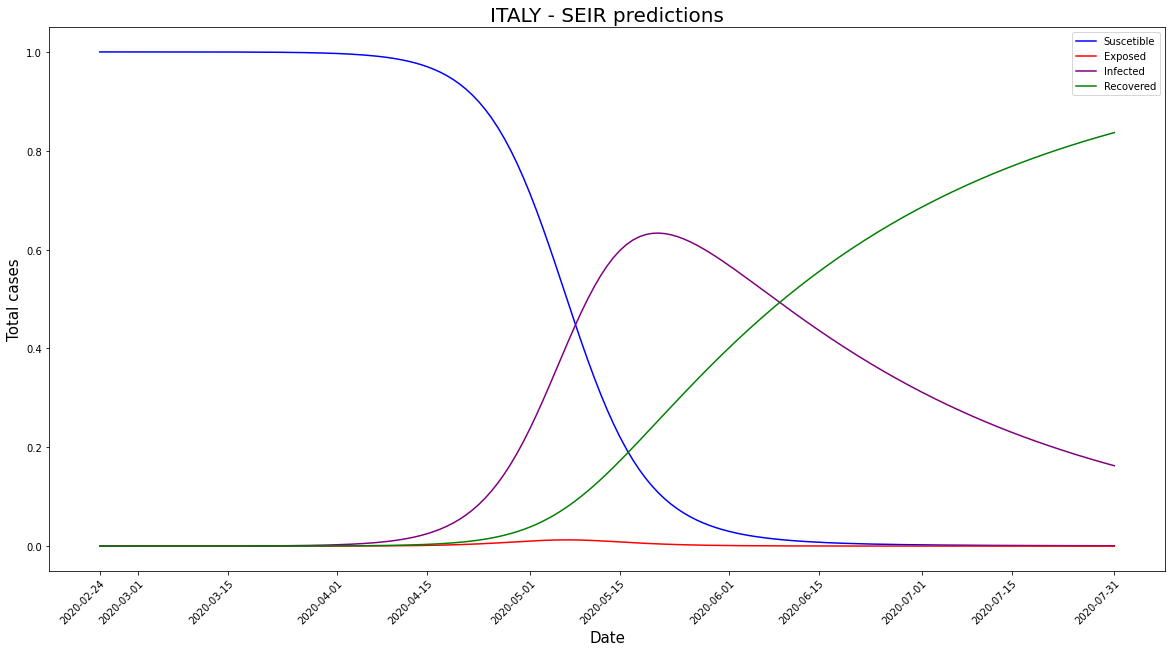

In [29]:
# Plot results
## Define Date axis to better visualization (only first/half/last day of every month)
time_axis = [time_pred[i] for i in [0,6,20,37,51,67,81,98,112,128,142,158]]
## Define plot object
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
## Plot SIR
sns.lineplot(x=time_pred, y=future_pred[:,0], ax=axes, color = 'blue')
sns.lineplot(x=time_pred, y=future_pred[:,1], ax=axes, color = 'red')
sns.lineplot(x=time_pred, y=future_pred[:,2], ax=axes, color = 'purple')
sns.lineplot(x=time_pred, y=future_pred[:,3], ax=axes, color = 'green')
plt.setp(axes.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
axes.legend(loc=1, labels=['Suscetible', 'Exposed', 'Infected','Recovered'], fontsize=10)
axes.set_title('ITALY - SEIR predictions', fontsize=20)
axes.set_xlabel('Date', fontsize=15)
axes.set_ylabel('Total cases', fontsize=15)
axes.set_xticks(time_axis);

### Commentary:
- Based in those results, Italy would achieve the maximum value in infected curve around half of may, after ~2.5 months with a population portion of ~60% infected!
- My predicted exposed curve is very low. This is possible given the EDO formula and the fact that my parameters were optmized based in Infected/Recovered curve. Besides that, a biological explanation could be presented: most of exposed people became infected **before** 02/24 in Italy.

## ICU usage analysis with different scenarios
This part is related to the task: **Which populations have contracted COVID-19 who require the ICU? And when does this occur in their disease course?**.

Before I answer this question, let's plot ICU usage prediction based in SEIR results. Considering **OMS Statement** that 5% of infected cases will require ICU:
![oms rule](https://user-images.githubusercontent.com/32513366/79801543-ab146500-8334-11ea-9347-764f3bbc128a.jpg)

Let's calculate ICU usage as % of SEIR infected curve:

In [30]:
# Calculate icu curve based in SEIR infected curve
future_pred_icu = 0.05*future_pred[:,2]

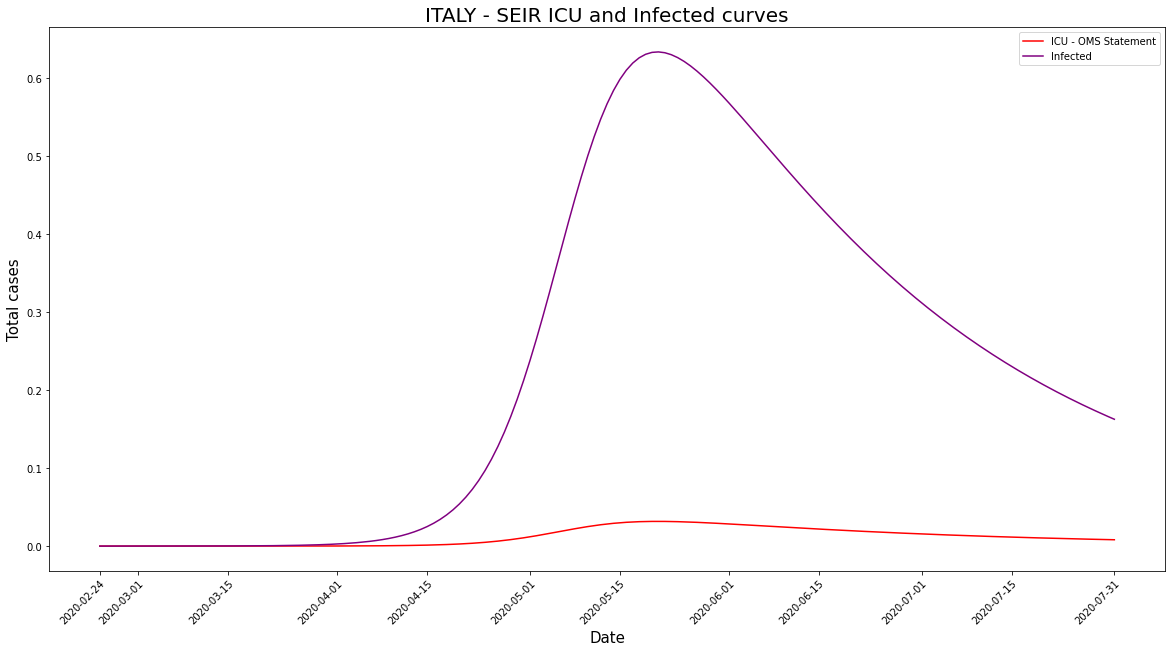

In [31]:
# Plot results
## Define plot object
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
## Plot SIR
sns.lineplot(x=time_pred, y=future_pred_icu, ax=axes, color = 'red')
sns.lineplot(x=time_pred, y=future_pred[:,2], ax=axes, color = 'purple')
plt.setp(axes.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
axes.legend(loc=1, labels=['ICU - OMS Statement','Infected'], fontsize=10)
axes.set_title('ITALY - SEIR ICU and Infected curves', fontsize=20)
axes.set_xlabel('Date', fontsize=15)
axes.set_ylabel('Total cases', fontsize=15)
axes.set_xticks(time_axis);

We got our ICU predicted curve!
Now, let's take some information related to [**ICU beds quantity in Italy**](https://en.wikipedia.org/wiki/List_of_countries_by_hospital_beds#cite_note-Rhodes2012-15).

Based in that source, Italy have 12.5 per 100,000 habitants. I will transform this result in absolute to create an array:

In [32]:
# ICU beds in Italy
icu_beds_value = 12.5*100000/N

# ICU beds array
icu_beds_100 = [icu_beds_value] * len(future_pred_icu)

Look that ```icu_beds_value``` implies a **total of ICU beds** in that country. A reasonable assumption is that not all ICU beds are available given to other patients who have been affected by other illnesses/problems. So I will evaluate possible **different ICU scenarios** applying some thresholds:
- 25% of free ICU beds
- 50% of free ICU beds
- 75% of free ICU beds

Besides 100% of icu beds.

In [33]:
# Create icu threshold scenarios - 25%
icu_beds_threshold = icu_beds_value*0.25
icu_beds_25 = [icu_beds_threshold] * len(future_pred_icu)
# Create icu threshold scenarios - 50%
icu_beds_threshold = icu_beds_value*0.50
icu_beds_50 = [icu_beds_threshold] * len(future_pred_icu)
# Create icu threshold scenarios - 75%
icu_beds_threshold = icu_beds_value*0.75
icu_beds_75 = [icu_beds_threshold] * len(future_pred_icu)

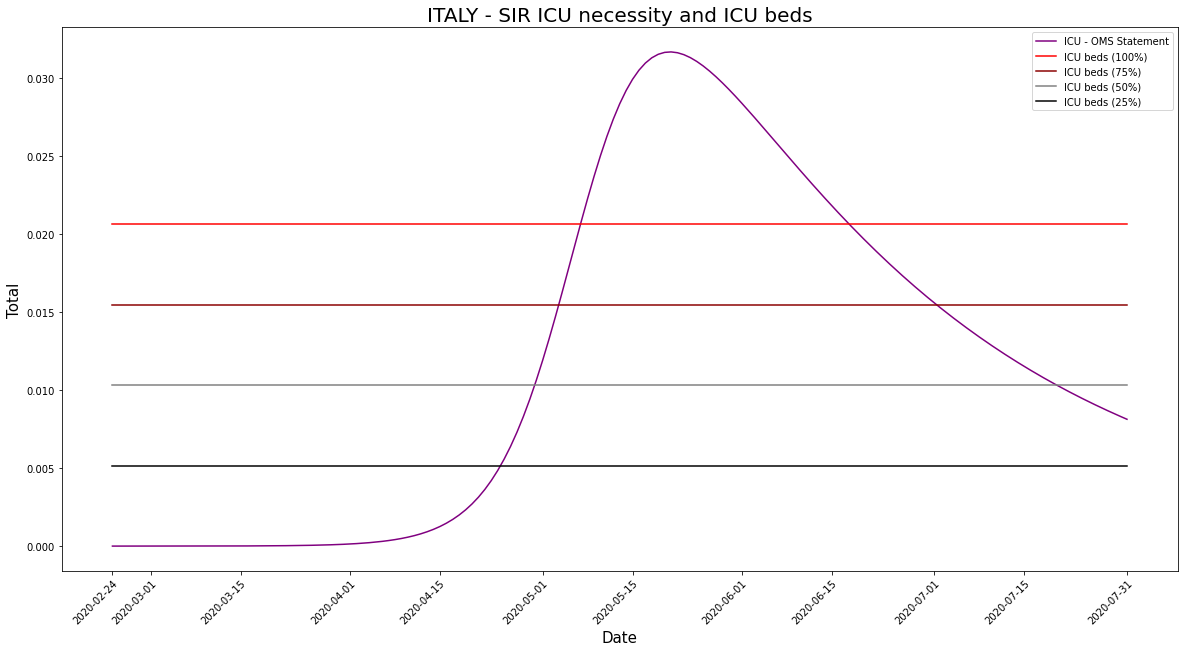

In [34]:
# Plot results
## Define plot object
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
## Plot SEIR
sns.lineplot(x=time_pred, y=future_pred_icu, ax=axes, color = 'purple')
sns.lineplot(x=time_pred, y=icu_beds_100, ax=axes, color = 'red')
sns.lineplot(x=time_pred, y=icu_beds_75, ax=axes, color = 'darkred')
sns.lineplot(x=time_pred, y=icu_beds_50, ax=axes, color = 'gray')
sns.lineplot(x=time_pred, y=icu_beds_25, ax=axes, color = 'black')
plt.setp(axes.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
axes.legend(loc=1, labels=['ICU - OMS Statement','ICU beds (100%)','ICU beds (75%)','ICU beds (50%)','ICU beds (25%)'], fontsize=10)
axes.set_title('ITALY - SIR ICU necessity and ICU beds', fontsize=20)
axes.set_xlabel('Date', fontsize=15)
axes.set_ylabel('Total', fontsize=15)
axes.set_xticks(time_axis);

### Commentaries:
- Based in this analysis, Italy ICUs in health care system would **bankrupt** around the beginning of May if they present 100% of ICU beds. If they present 25% (still a higher number) of free beds, they would **bankrupt** around april last week.
    - I say that a 25% still a higher value based in my reality: In Brazil we only have 7-8% of free ICU beds.
- ICU predicted curve have the same format as Infected curve and this is a good approximation: in real world, ICU necessity is create based in the infected numbers.
- Note that those results are underestimated. I calculated **all the beds** that Italy have and some limits thresholds. This doesn't count the difference between adult/pediatric beds, number of real vacant beds (after all, before the virus spread these beds could already be used by other patients) and country states differences (each Italy state have your ICU beds %, so a state A could bankrupt before a state B for example). If you count those situations and keep infection/recovery rate constant the health care system would bankrupt earlier than my prediction. As you can see, given a 25% free beds Italy would suffer a **ICU bankrupt** one week earlier than 100%.
- The **critical period would be between 04/15 and 05/01**. This could be changed with lockdown/isolation techniques for population. So in the end, this prediction shows what would happen if and only if the parameters are static i.e. rulers maintain the current country situation without improving or worsening after 02/24.

# Case Study II: Spain
![1024px-Flag_of_Spain svg](https://user-images.githubusercontent.com/32513366/80283259-9a753d80-86ec-11ea-8313-236948a6014f.png)

Here I did the same process that I made for Italy. Spain shows a comparable situation to Italy (something that is bad).

## Exploratory Data Analysis

### COVID-19 Spain Development
Here I will visualize each curve for:
- Infected
- Recovered
- ICU

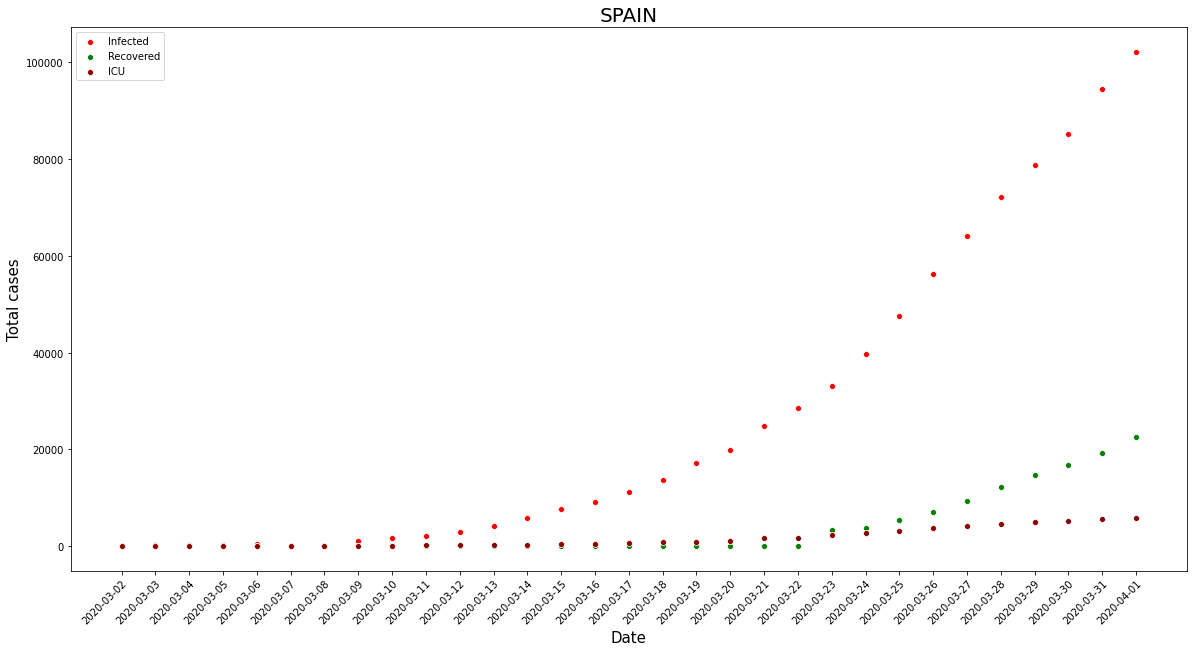

In [35]:
# Define plot object
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,10))

# Define df to plot here!
df = spn_status

# Plots - ITALY
sns.scatterplot(x='date', y='infected', data=df, ax=axes, color = 'red')
sns.scatterplot(x='date', y='recovered', data=df, ax=axes, color = 'green')
sns.scatterplot(x='date', y='icu', data=df, ax=axes, color = 'darkred')
plt.setp(axes.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
axes.legend(loc=2, labels=['Infected','Recovered','ICU'], fontsize=10)
axes.set_title('SPAIN', fontsize=20)
axes.set_xlabel('Date', fontsize=15)
axes.set_ylabel('Total cases', fontsize=15);

### Commentary:
- Infected curve , in red, grows exponentially as Italy.
- Recovered curve, in green, after some time grows with Infected curve as Italy.
- ICU curve, in dark red, increase with a smaller percentage of Infected curve, but more slower compare Italy. 

### ICU Ratio
Here I will eval through a plot the ICU ratio related to Infected cases.


In [36]:
# Create a icu_ratio in % for SPAIN
for i in range(0, len(spn_status)):
    if spn_status.loc[i, 'icu'] != 0 and spn_status.loc[i, 'infected'] != 0:
        spn_status.loc[i, 'icu_ratio'] = round(100*(float(spn_status.loc[i, 'icu'])/float(spn_status.loc[i, 'infected'])), 2)
    else:
        spn_status.loc[i, 'icu_ratio'] = 0

In [37]:
# Get some fast statistics: maximum, minimum and average ICU ratio - SPAIN
print('### Spain')
print('Maximum ICU ratio: ', np.nanmax(spn_status['icu_ratio']))
print('Average ICU ratio: ', round(np.nanmean(spn_status['icu_ratio']),2))
print('Minimum ICU ratio: ', np.nanmin(spn_status['icu_ratio']))

### Spain
Maximum ICU ratio:  7.12
Average ICU ratio:  5.05
Minimum ICU ratio:  0.0


Let's see the ICU ratio through time:

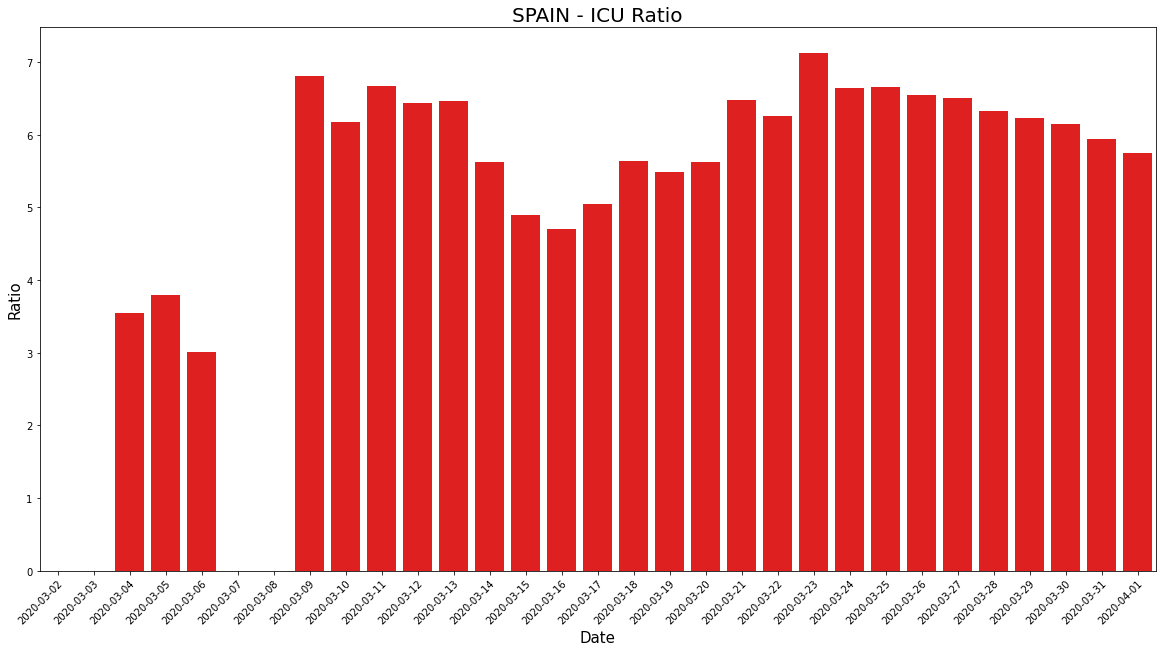

In [38]:
# Define plot object
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,10))

# Define df to plot here!
df = spn_status

# Plot - ITALY
sns.barplot(x='date', y='icu_ratio', data=df, ax=axes, color = 'red')
plt.setp(axes.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
axes.set_title('SPAIN - ICU Ratio', fontsize=20)
axes.set_xlabel('Date', fontsize=15)
axes.set_ylabel('Ratio', fontsize=15);

Look that Spain got a minimum icu rate equal zero and the graph **ICU Ratio** show some nonexistent bars.  This could be a good sign OR a subnotification problem. Let's see in depth Italy/Spain dataset:

In [39]:
ita_status

,date,infected,icu,recovered,icu_ratio
0,2020-02-24,229,26,1,11.35
1,2020-02-25,322,35,1,10.87
2,2020-02-26,400,36,3,9.00
3,2020-02-27,650,56,45,8.62
4,2020-02-28,888,64,46,7.21
5,2020-02-29,1128,105,50,9.31
6,2020-03-01,1694,140,83,8.26
7,2020-03-02,2036,166,149,8.15
8,2020-03-03,2502,229,160,9.15
9,2020-03-04,3089,295,276,9.55


Italy doesn't show any strong evidence for subnotification. Now, let's see spain dataset:

In [40]:
spn_status

,date,infected,icu,recovered,icu_ratio
0,2020-03-02,114.0,0.0,0.0,0.00
1,2020-03-03,150.0,0.0,0.0,0.00
2,2020-03-04,198.0,7.0,0.0,3.54
3,2020-03-05,237.0,9.0,0.0,3.80
4,2020-03-06,365.0,11.0,0.0,3.01
5,2020-03-07,0.0,0.0,0.0,0.00
6,2020-03-08,0.0,0.0,0.0,0.00
7,2020-03-09,999.0,68.0,0.0,6.81
8,2020-03-10,1622.0,100.0,0.0,6.17
9,2020-03-11,2128.0,142.0,0.0,6.67


Somehow, I jumped from 0 recovered in 03/02 to 3355 in 03/23! Basically we have here a 

### subnotification problem

of three weeks in recovered column. To continue with SEIR analysis and use LS optimization, I will only considerer to minimize the prediction error with respect to:
- infected column 
- recovered column portion from 03/23 to 04/01 

## SEIR Model Solution

### Define [country population (N) in Spain](https://en.wikipedia.org/wiki/Spain)

In [41]:
# Country population (~)
N = 1000000*47.01

### Define start conditions
I will use the same assumptions present in Italy case study i.e.:

**e(0) = i(5) - i(4)** (Exposed initial value is equal to new infected in day 5)

**s(0) = 1 - e(0) - i(0)** (Suscetible is total population minus infected/exposed portion)

In [42]:
# Define Initial Condition (necessary for ODE solve)
I_start = spn_status.loc[0, 'infected']/N
E_start = (spn_status.loc[4, 'infected'] - spn_status.loc[3, 'infected'])/N
S_start = 1 - E_start - I_start
R_start = spn_status.loc[0, 'recovered']/N
## Set this values as a tuple
ic = (S_start, E_start, I_start, R_start)

In [43]:
print('Start condition:')
print('s(0): ', ic[0])
print('e(0): ', ic[1])
print('i(0): ', ic[2])
print('r(0): ', ic[3])

Start condition:
s(0):  0.9999948521591151
e(0):  2.722824930865773e-06
i(0):  2.4250159540523294e-06
r(0):  0.0


Given the fact that Italy only had 1 recovered, I will let this initial condition for spain of r(0) equals to zero pass.

### Prepare data to optimization

In [44]:
# Define a time array measure in days
time_opt = range(0, len(spn_status))

# Create a tuple with the true values in fraction for Infected/Recovered cases (necessary for error measurement)
i_r_true = (list(spn_status['infected']/N), list(spn_status.loc[21:, 'recovered']/N))

# Define a start guess for our parameters [infection_rate, recovered rate]
params_start_guess = [0.01, 0.001, 0.01]

### Change ```fit_seir_model``` to evaluate different recovered column

In [45]:
# FUNCTION - Auxiliar function to find the best parameters
def fit_seir_model(params_to_fit, t, initial_condition, i_r_true):
    # Calculate ODE solution for possible parameter, return values to each dependent variable:
    # (s, e, i and r)
    fit_result = calculate_seir_model(params_to_fit, t, initial_condition)
    
    # Calculate residual value between predicted VS true
    ## Note: ode_result[0] is S result
    residual_i = i_r_true[0] - fit_result[:,2]
    residual_r = i_r_true[1] - fit_result[21:,3]

    # Create a np.array of all residual values for both (i) and (r)
    residual = np.concatenate((residual_i, residual_r))
    
    # Return results
    return residual

### Optimization process

In [46]:
optimal_params, sucess = optimize.leastsq(fit_seir_model,
                                          x0=params_start_guess,
                                          args=(time_opt, ic, i_r_true),
                                          ftol=1.49012e-15)

In [47]:
print('## Spain')
print('Optimize infection rate: ', optimal_params[0])
print('Optimize recovered rate: ', optimal_params[1])
print('Optimize exposed rate: ', optimal_params[2])

## Spain
Optimize infection rate:  78.62282127961734
Optimize recovered rate:  0.04006922371618912
Optimize exposed rate:  0.24958411796841815


### Compare the curves (true/pred)

In [48]:
# Get the optimal parameters
ir = optimal_params[0]
rr = optimal_params[1]
er = optimal_params[2]

# Calculate a curve based on those parameters
fit_result = calculate_seir_model((ir, rr, er), time_opt, ic)

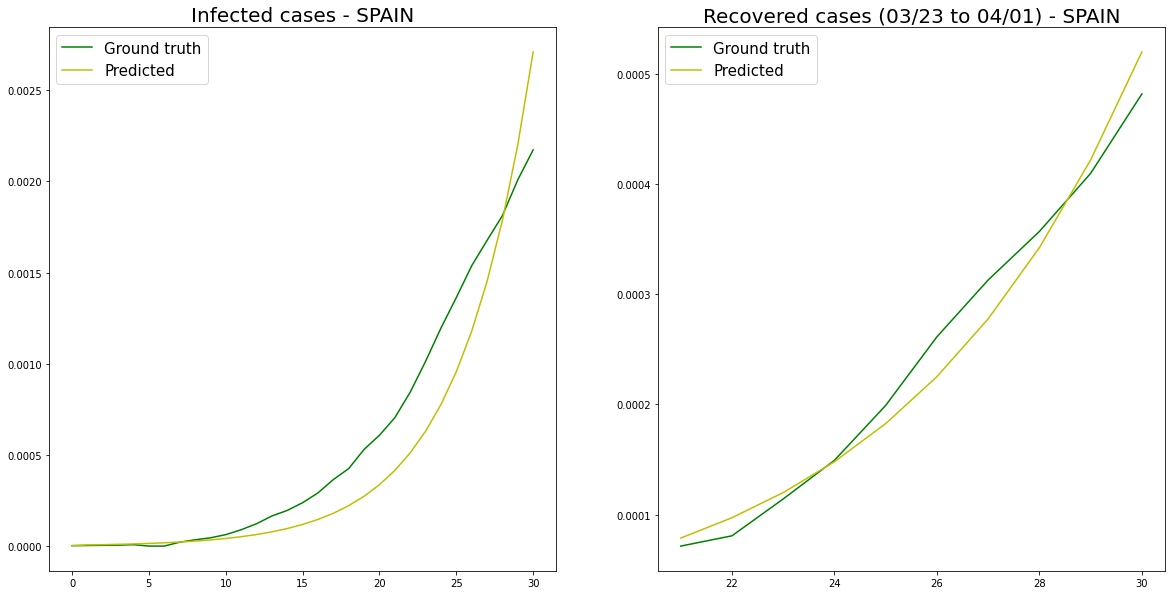

In [49]:
# Plot the results for Infected/Recovered
## Define plot object
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

## Plot process
axes[0].plot(time_opt, i_r_true[0], 'g')
axes[0].plot(time_opt, fit_result[:,2], 'y')
axes[0].legend(['Ground truth', 'Predicted'],loc=2, fontsize=15)
axes[0].set_title('Infected cases - SPAIN',fontsize=20)
axes[1].plot(range(21,31), i_r_true[1], 'g')
axes[1].plot(range(21,31), fit_result[21:,3], 'y')
axes[1].legend(['Ground truth', 'Predicted'],loc=2, fontsize=15)
axes[1].set_title('Recovered cases (03/23 to 04/01) - SPAIN',fontsize=20);

### Commentaries:
As we can see the optimization found a excelent approximation! A reason could be that I have less points to compare. But they are free of a possible noise related to recovered subnotification.

Besides that, the model shows the same dynamic as the original curves which means good sign!


## SEIR predictions until July
Let's see this model predictions until July.

In [50]:
# Get prediction full period time in datetime object and the convert to string
datetime_pred = pd.date_range(start="2020-03-02",end="2020-07-31", freq='D')
time_pred = [x.strftime("%Y-%m-%d") for x in datetime_pred]

In [51]:
# Get a list from 01/April to 31/July 
time_pred_range = range(0, len(time_pred))

In [52]:
# Calculate a SIR prediction 
future_pred = calculate_seir_model((ir, rr, er), time_pred_range, ic)

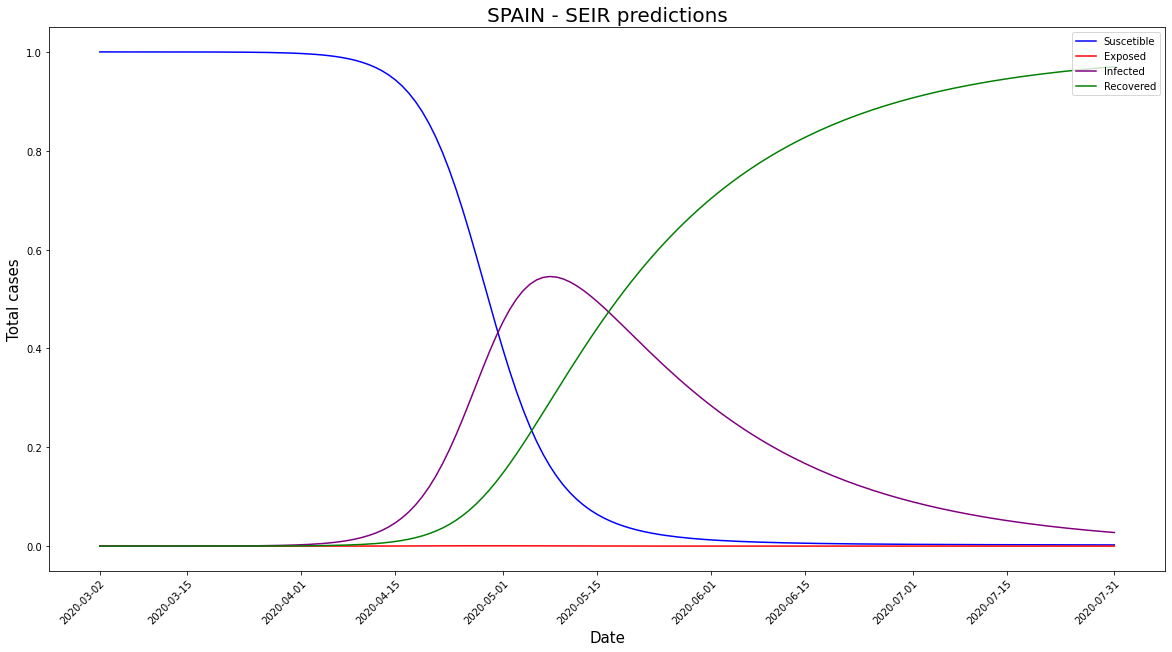

In [53]:
# Plot results
## Define Date axis to better visualization (only first/half/last day of every month)
time_axis = [time_pred[i] for i in [0,13,30,44,60,74,91,105,121,135, 151]]
## Define plot object
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
## Plot SIR
sns.lineplot(x=time_pred, y=future_pred[:,0], ax=axes, color = 'blue')
sns.lineplot(x=time_pred, y=future_pred[:,1], ax=axes, color = 'red')
sns.lineplot(x=time_pred, y=future_pred[:,2], ax=axes, color = 'purple')
sns.lineplot(x=time_pred, y=future_pred[:,3], ax=axes, color = 'green')
plt.setp(axes.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
axes.legend(loc=1, labels=['Suscetible', 'Exposed', 'Infected','Recovered'], fontsize=10)
axes.set_title('SPAIN - SEIR predictions', fontsize=20)
axes.set_xlabel('Date', fontsize=15)
axes.set_ylabel('Total cases', fontsize=15)
axes.set_xticks(time_axis);


### Commentary:
- Based in those results, Spain would achieve the infected maximum value in start of may, a two weeks difference compared to Italy with the same infetected population portion: ~60%!
- The exposed curve is almost forgetable. This could mean that infection was already too strong (given the higher infection rate parameter) and most of the population passed from exposed to infected **before 03/02**. Italy presented the same pattern, but more smoothy. Another proof to corroborate this fact is that spain dataset start one week after Italy dataset.

## ICU usage analysis with different scenarios
This part is related to the task: **Which populations have contracted COVID-19 who require the ICU? And when does this occur in their disease course?** for Spain case study and is based in Italy case study assumptions for ICU values.

Let's calculate ICU usage curve as 5% of SEIR infected curve using OMS statement:


In [54]:
# Calculate icu curve based in SEIR infected curve
future_pred_icu = 0.05*future_pred[:,2]

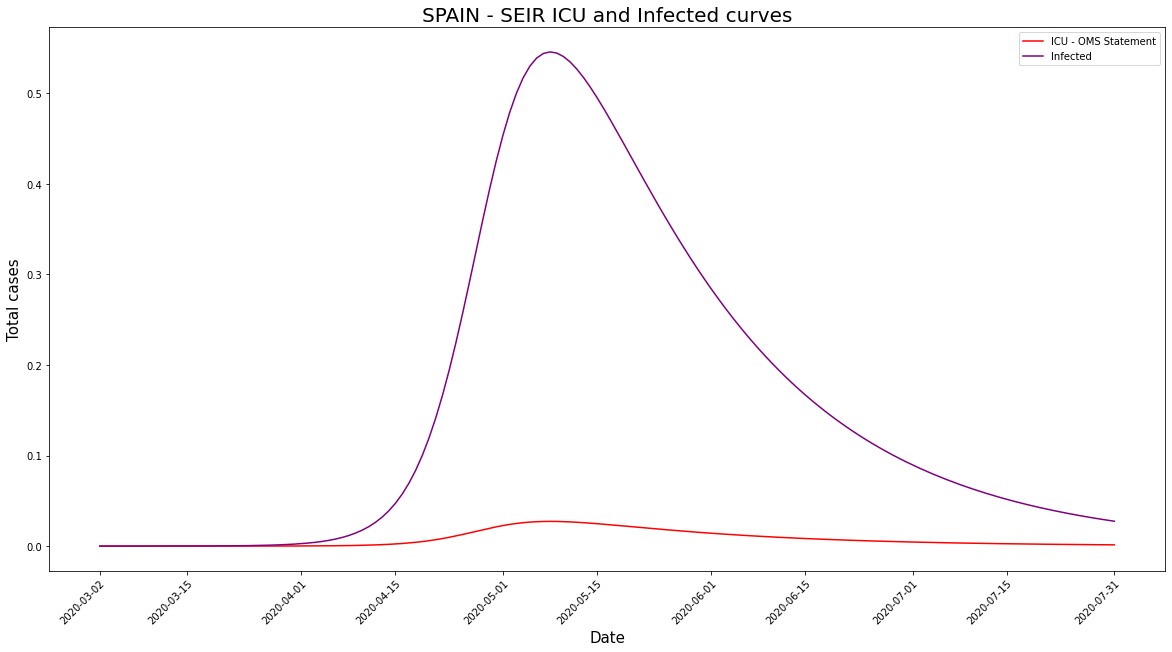

In [55]:
# Plot results
## Define plot object
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
## Plot SIR
sns.lineplot(x=time_pred, y=future_pred_icu, ax=axes, color = 'red')
sns.lineplot(x=time_pred, y=future_pred[:,2], ax=axes, color = 'purple')
plt.setp(axes.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
axes.legend(loc=1, labels=['ICU - OMS Statement','Infected'], fontsize=10)
axes.set_title('SPAIN - SEIR ICU and Infected curves', fontsize=20)
axes.set_xlabel('Date', fontsize=15)
axes.set_ylabel('Total cases', fontsize=15)
axes.set_xticks(time_axis);


We got our ICU predicted curve! (a sharper curve compared to Italy is verified in Infected curve)

Now, let's take some information related to [**ICU beds quantity in Spain**](https://en.wikipedia.org/wiki/List_of_countries_by_hospital_beds#cite_note-Rhodes2012-15).

Based in that source, Spain have 9.7 per 100,000 habitants (less than Italy). I will transform this result in absolute to create an array:

In [56]:
# ICU beds in Spain
icu_beds_value = 9.7*100000/N

# ICU beds array
icu_beds_100 = [icu_beds_value] * len(future_pred_icu)

Look that ```icu_beds_value``` implies a **total of ICU beds** in that country. I will create **different ICU scenarios** applying some thresholds:
- 25% of free ICU beds
- 50% of free ICU beds
- 75% of free ICU beds

Besides 100% of free ICU beds


In [57]:
# Create icu threshold scenarios - 25%
icu_beds_threshold = icu_beds_value*0.25
icu_beds_25 = [icu_beds_threshold] * len(future_pred_icu)
# Create icu threshold scenarios - 50%
icu_beds_threshold = icu_beds_value*0.50
icu_beds_50 = [icu_beds_threshold] * len(future_pred_icu)
# Create icu threshold scenarios - 75%
icu_beds_threshold = icu_beds_value*0.75
icu_beds_75 = [icu_beds_threshold] * len(future_pred_icu)

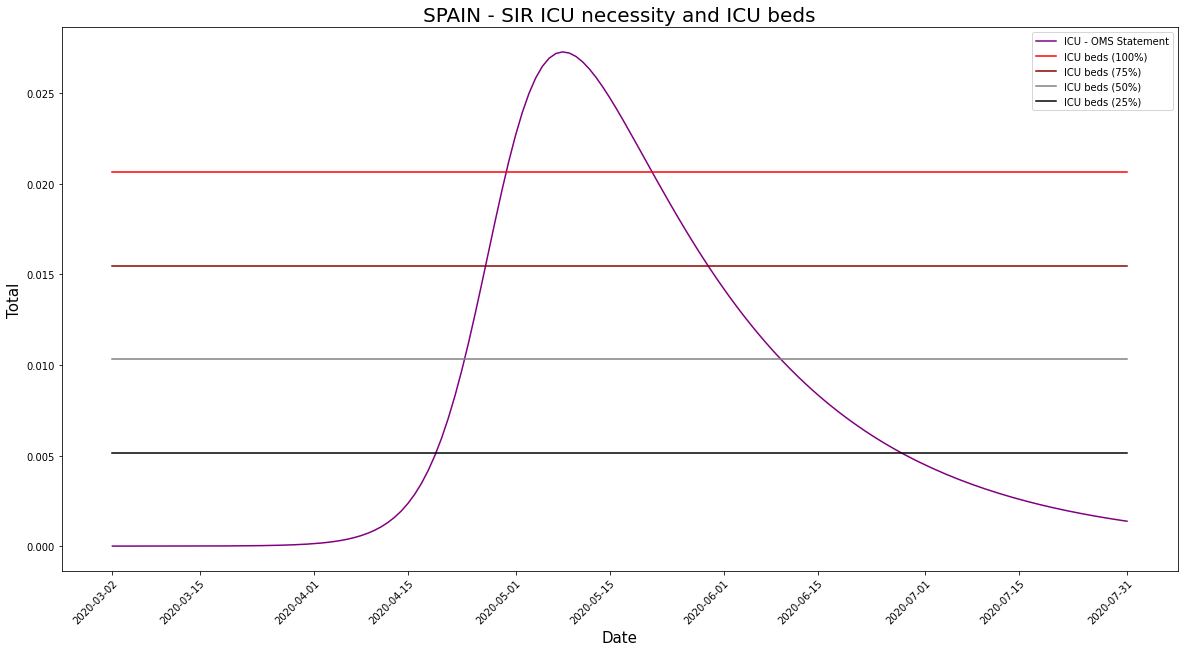

In [58]:
# Plot results
## Define plot object
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
## Plot SIR
sns.lineplot(x=time_pred, y=future_pred_icu, ax=axes, color = 'purple')
sns.lineplot(x=time_pred, y=icu_beds_100, ax=axes, color = 'red')
sns.lineplot(x=time_pred, y=icu_beds_75, ax=axes, color = 'darkred')
sns.lineplot(x=time_pred, y=icu_beds_50, ax=axes, color = 'gray')
sns.lineplot(x=time_pred, y=icu_beds_25, ax=axes, color = 'black')
plt.setp(axes.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
axes.legend(loc=1, labels=['ICU - OMS Statement','ICU beds (100%)','ICU beds (75%)','ICU beds (50%)','ICU beds (25%)'], fontsize=10)
axes.set_title('SPAIN - SIR ICU necessity and ICU beds', fontsize=20)
axes.set_xlabel('Date', fontsize=15)
axes.set_ylabel('Total', fontsize=15)
axes.set_xticks(time_axis);

### Commentaries:
- Based in this analysis, Spain ICUs in health care system would **bankrupt** before first of May if they present 100% of ICU beds. If they present 25% (still a higher number) of free beds, they would **bankrupt** around 04/15.
- The **critical period would be between 04/15 and 05/01**. This could be changed with lockdown/isolation techniques for population.
- Spain scenario is worst than Italy scenario given a sharper ICU curve.
- The difference between the ICU threshold are minimal: All ICU bankrupt would happen between 04/15 and 05/01.

# Case Study III: Brazil
![1200px-Flag_of_Brazil svg](https://user-images.githubusercontent.com/32513366/80283270-b8db3900-86ec-11ea-9ec8-3f419dcc0e18.png)

Brazil analysis will diverge from previous case studies. This dataset doesn't contain any specific temporal relation between your samples what prevents me from applying an optimization to create a SEIR model.

Given that, I will try to provide an clinical analysis relate to ICU patients characteristics. 

## Missing Analysis
Given the fact that I know this dataset given a previous work in [Einstein Data Challenge](https://www.kaggle.com/kaikewreis/a-second-end-to-end-solution-for-covid-19), I need to visualize my missing samples through a briefly missing analysis.

**PS**: To see a complete missing analysis over this dataset go to [my notebook here](https://www.kaggle.com/kaikewreis/a-second-end-to-end-solution-for-covid-19)

### Missing % for each column

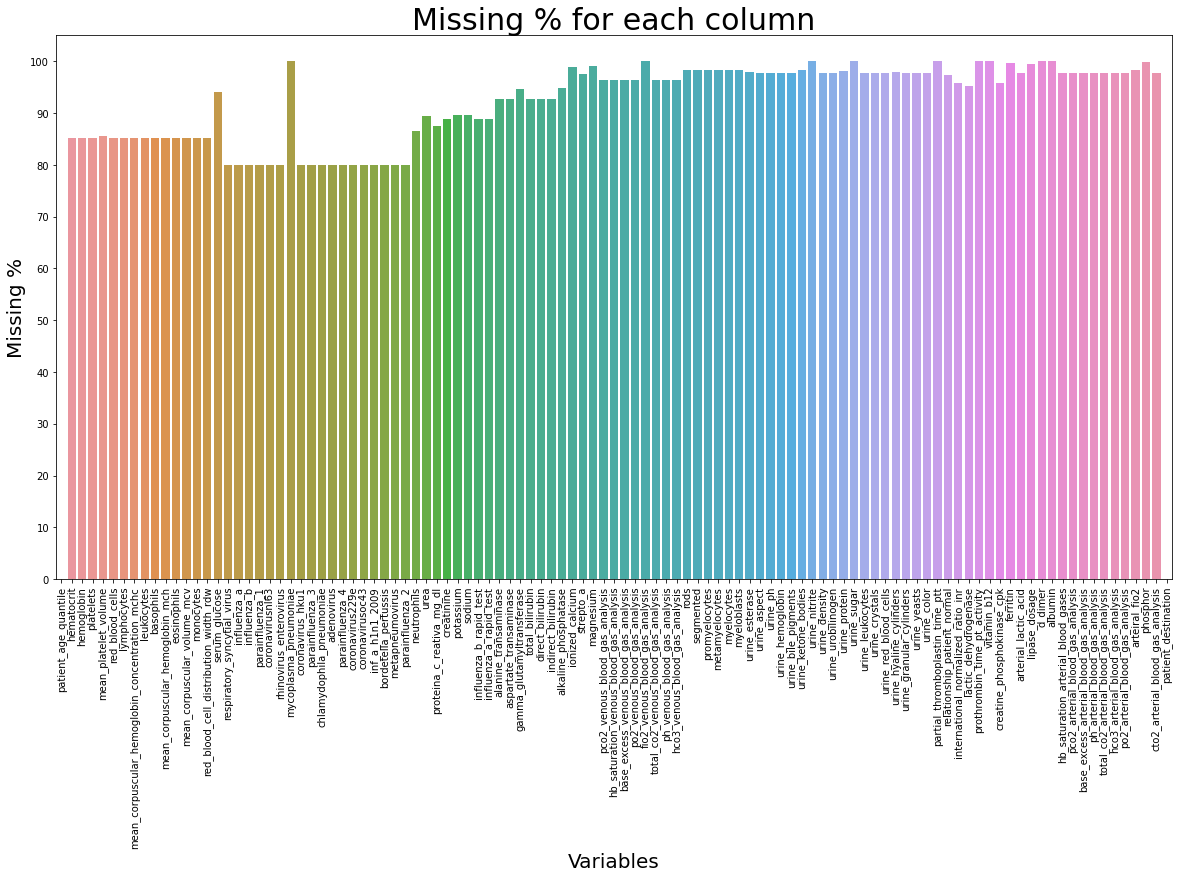

In [59]:
# Eval missing value for each column again
nan_per_column = pd.DataFrame(df_bra_status.isna().sum(),columns=['nanValues']).reset_index()

# Calculate NaN %
for i in range(0,len(nan_per_column)):
    nan_per_column.loc[i, 'nanValuesPct'] = 100*round(nan_per_column.loc[i, 'nanValues']/len(df_bra_status),3)
    
# Plot - % of missing rows for each column
plt.figure(figsize=(20,10))
sns.barplot(x="index", y="nanValuesPct", data=nan_per_column)
plt.xlabel('Variables', fontsize=20)
plt.ylabel('Missing %', fontsize=20)
plt.title('Missing % for each column', fontsize=30)
plt.yticks([0,10,20,30,40,50,60,70,80,90,100])
plt.xticks(rotation=90);

### Commentaries:
- Through this plot, you can see that we have tons of missing values (higher than 80% of missing for each column).
- This graph show a problematic control over samples: a study dataset should not present tons of missing for a critical study as COVID-19 control.
- Based in this dataset, I can only provide a AGE study for all positive cases given the complete column

### Missing % for hospitalize patients
I will plot the same graph for a dataset that contains only **hospitalized patients**: regular ward, semi intensive unit and intensive care unit 

In [60]:
# Visualize how much hospitalized patient samples do we have
df_bra_status['patient_destination'].value_counts()

no_hospitalization     506
regular_ward            36
intensive_care_unit      8
semi_intensive_unit      8
Name: patient_destination, dtype: int64

In [61]:
# Create a new dataset to contains only hospitalized patients
df_bra_hosp_status = df_bra_status[df_bra_status['patient_destination'] != 'no_hospitalization']

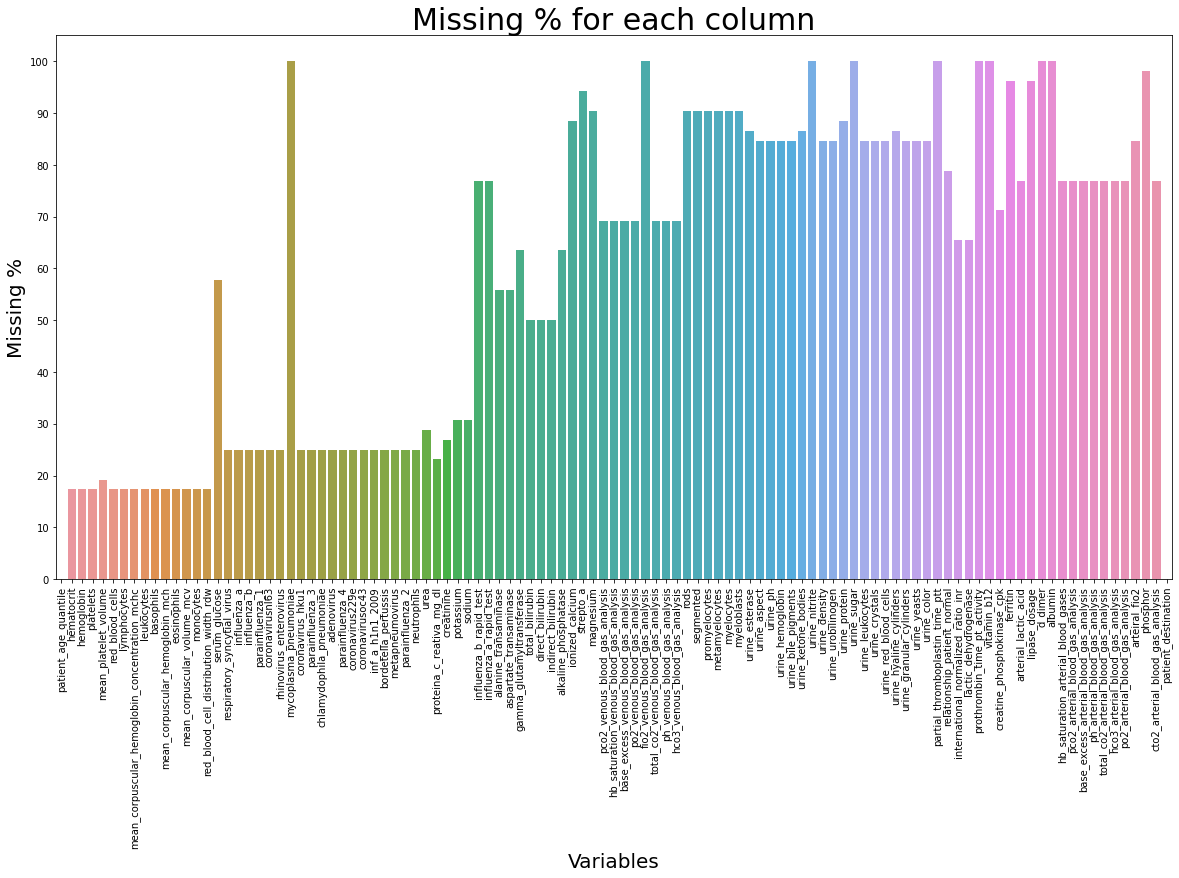

In [62]:
# Missing plot
# Eval missing value for each column again
nan_per_column = pd.DataFrame(df_bra_hosp_status.isna().sum(),columns=['nanValues']).reset_index()

# Calculate NaN %
for i in range(0,len(nan_per_column)):
    nan_per_column.loc[i, 'nanValuesPct'] = 100*round(nan_per_column.loc[i, 'nanValues']/len(df_bra_hosp_status),3)
    
# Plot - % of missing rows for each column
plt.figure(figsize=(20,10))
sns.barplot(x="index", y="nanValuesPct", data=nan_per_column)
plt.xlabel('Variables', fontsize=20)
plt.ylabel('Missing %', fontsize=20)
plt.title('Missing % for each column', fontsize=30)
plt.yticks([0,10,20,30,40,50,60,70,80,90,100])
plt.xticks(rotation=90);

### Commentaries:
- I still have a higher number of missings. This is sad.
- Given the fact that I only have 52 samples related to positive hospitalized cases of a population of ~209.000.000 I don't think that clinical analysis would reflect any useful information for some reasons:
    - This represent only 4.1e-7 of 60% of my population, this is a really small sample size
    - Still have tons of missing

So a brief missing analysis over this dataset shows that we have a major **subnotification problem** (because I live in Brazil, until this date (04/25) this problem is consistent).


## Exploratory Data Analysis

The state of missing data in the database in Brazil allows me to make only a brief analysis in relation to the age of patients who contracted COVID-19. This brief analysis **does not reflect** the general situation of the country, which is immense! I say this because I'm using only ~500 samples (small value).

### Change quantile column to age range column
Based in this [commentary](https://www.kaggle.com/einsteindata4u/covid19/discussion/139506) I will use this provided range to give more meaning to my analysis besides an "quantile study". My age interval is given as:
- 0 means age from 0 to 5
- 1 means age from 6 to 10
- ...
- 19 means age from 96 to 100

In [63]:
# Define age and quantile list
age_list = ['0-5','6-10','11-15','16-20','21-25','26-30','31-35','36-40','41-45','46-50','51-55','56-60','61-65','66-70','71-75','76-80','81-85','86-90','91-95','96-100']

# Create specific column
df_bra_status['age_interval'] = np.nan

In [64]:
for i in range(0, len(df_bra_status)):
    # Get index related (age_list have the equivalent index of patient_age_quantile_column)
    age_list_index = int(df_bra_status.loc[i, 'patient_age_quantile'])
    # Insert range
    df_bra_status.loc[i, 'age_interval'] = age_list[age_list_index]    

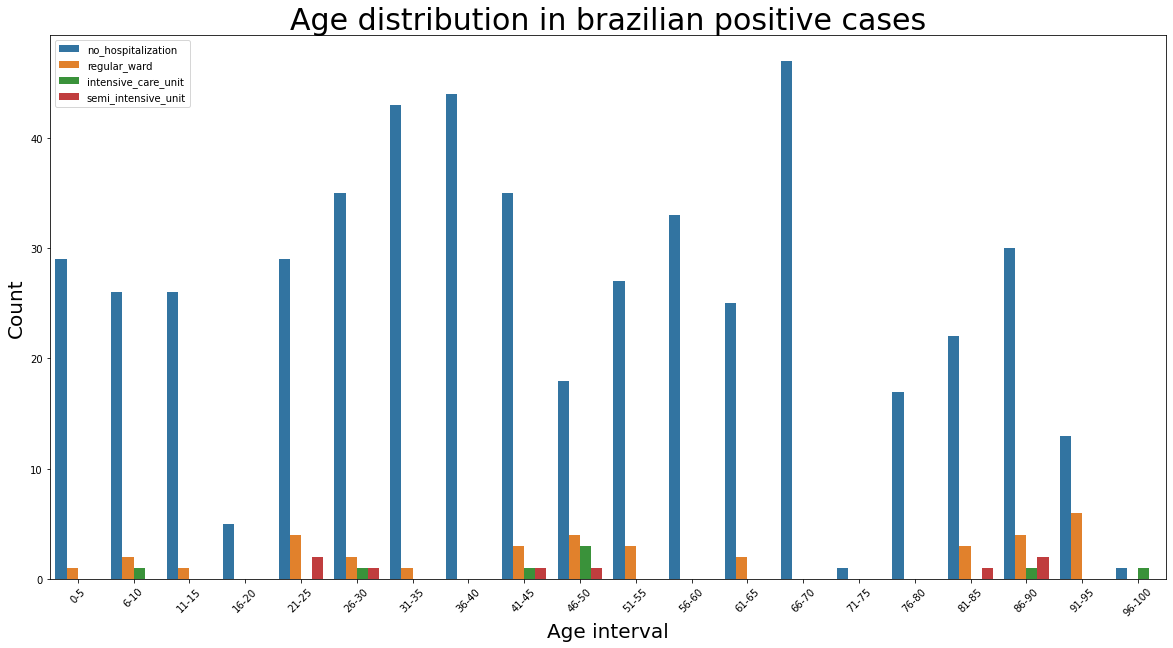

In [65]:
plt.figure(figsize=(20,10))
# Plot both columns
sns.countplot(x='age_interval', hue='patient_destination', data=df_bra_status)
plt.xlabel('Age interval', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title('Age distribution in brazilian positive cases', fontsize=30)
plt.legend(loc=2)
plt.xticks(range(0,20), age_list, rotation=45);

### Commentaries:
- The case majority doesn't need any hospitalization
- All hospitalization cases are well distributed
- I can not gave any useful information related to ICU usage here given the fact that I only got 8 samples for Brazil. In total I only have 52 hospitalized cases and none pattern could be retrieved.

# Overall Conclusions
- Given the higher % of missing in Brazil dataset and a small sample quantity related to ICU usage I don't have the necessary "sample power" i.e. **statistically significant sample number** to provide any useful information to procede with ICU usage in this country. That dataset only shows:
    - Brazil was at covid pandemic start due to the lack of hospitalization
    - Subnotification can be a problem in this country given the higher % of missing data
- Given my case study over Italy/Spain, I didn't have enough information to say which patient will require an ICU beds. **But**, through SEIR analysis after 01/may given a constant infection/recovery/exposed rate (no action is taken) the doctors would need to choose who lives or die and at this point technical factors doesn't matter so much (worst scenario).
- This approach can be applied for any country, state or city and is very helpful to understand what is happening. Your implementation is documented here.
- An important note is that SEIR and SIR assumes that a recovered person is **immune** to COVID. So, if later science discover that COVID can be caught again, this model is not recommended (or will require some changes in your equations).
- My results shows that **Spain situation is worst than Italy** at march (most of the data come from this period), given the evidences:
    - They have less ICUs beds and a higher Infection curve
    - Through my ICU different scenarios analysis Spain ICUs health care system would bankrupt at least one/two weeks earlier than Italy
    - Spain showed a fast infected curve than Italy. Looking at SEIR parameters we can see why: infection rate goes from 3.11 in Italy to 76.8 in Spain. Recovery rate didn't show a better improvement to change this: 0.02 in Italy against 0.04 in Spain (still lower compared Spain infection rate magnitude).

Basically, I hope that Spain took action after 01/04 to avoid this scenario!

## Real world application:
- My optimization approach could be applied by any scientist/analyst in any city:
    - Given the initial curve, optimize your parameters and propose techniques as isolation/lockdown to minimize infection rate
    - Apply your solution
    - After a period you evaluate the actual scenario to verify if your proposed solutions had impact
    - When the model start to diverge from real curve it's time to optimize your parameters again based in your actual curve

This can be done in a loop. Keeping the rates saved, you can evaluate the progress of your country/state/city until you flatten the curve!